

## 🧾 Problem Definition: Garbage Classification V2

**Objective:**
To develop an automated image classification system that accurately identifies and classifies garbage items into one of twelve predefined waste categories using computer vision and machine learning techniques.

**Context:**
Proper garbage classification is crucial for effective recycling, waste management, and environmental sustainability. Manual sorting is time-consuming, error-prone, and labor-intensive. An intelligent system capable of automatically recognizing the type of waste in real-world images can significantly improve the efficiency of waste segregation processes, particularly in smart recycling bins and automated waste sorting facilities.

**Dataset Description:**
The dataset consists of approximately 15,150 RGB images categorized into the following 12 classes:

* Cardboard
* Paper
* Plastic
* Metal
* Brown Glass
* Green Glass
* White Glass
* Trash (general)
* Biological Waste
* Batteries
* Shoes
* Clothes

Each image depicts a single garbage item in various lighting conditions, backgrounds, and angles. The images are grouped by class into separate folders, making it suitable for supervised learning.

**Problem Type:**

* Multi-class Image Classification

**Input:**

* A color image (e.g., `.jpg` or `.png`) depicting a single waste item.

**Output:**

* A class label indicating the type of garbage (e.g., "plastic", "paper", "metal", etc.).

**Evaluation Metrics:**

* **Accuracy**: Overall classification correctness.
* **Precision, Recall, and F1-Score** (per class): Especially important to monitor performance on minority classes (e.g., batteries or shoes).
* **Confusion Matrix**: To visualize model strengths and weaknesses across classes.

**Challenges:**

* **Class Imbalance**: Some categories have significantly fewer images than others.
* **Intra-class Variability**: Items within the same class (e.g., plastic containers vs. plastic bags) may look very different.
* **Inter-class Similarity**: Some categories may appear visually similar (e.g., brown vs. green glass).
* **Real-world Noise**: Variations in lighting, background clutter, and image quality.

**Goal:**
To train a robust deep learning model capable of generalizing well across all 12 classes and deploying it in applications like smart bins, mobile apps for waste sorting guidance, or industrial waste-sorting robotics.




#### Main tools

In [56]:
import os
import time
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import seaborn as sns
import requests
from io import BytesIO

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



## Explore The Datasets

In [14]:
dataset_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'


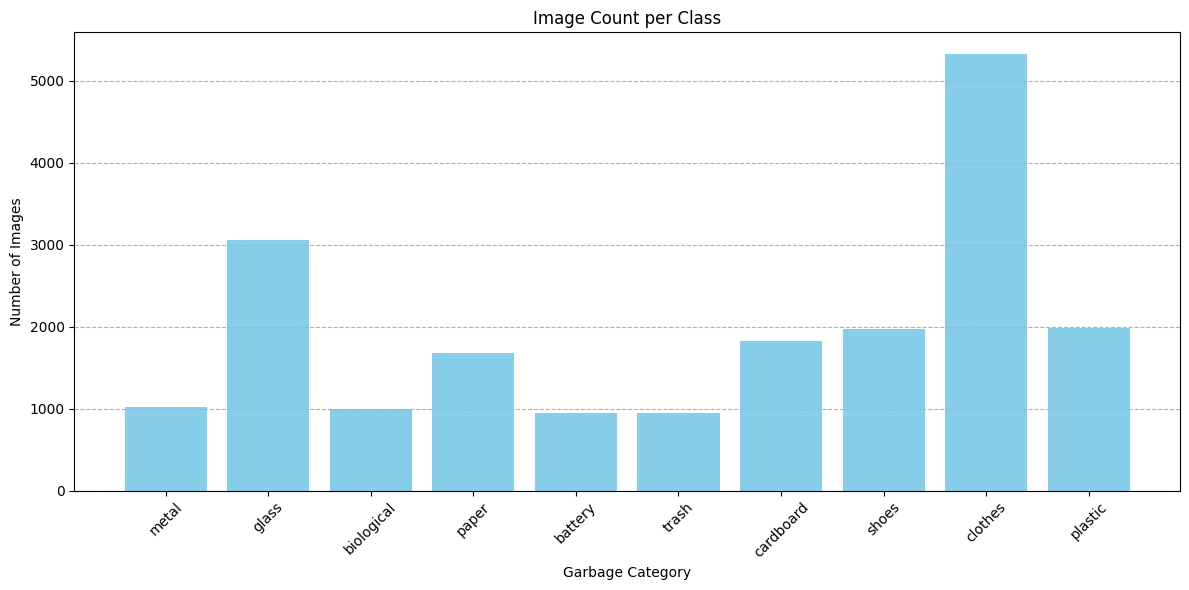

In [15]:
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls)))
                for cls in os.listdir(dataset_path)}

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Image Count per Class")
plt.xlabel("Garbage Category")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()


In [17]:
image_shapes = []

for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    for img_file in os.listdir(class_path)[:50]:  # sample 50 per class
        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            image_shapes.append(img.size)

# Convert to numpy array for statistics
widths, heights = zip(*image_shapes)

print(f"Average image width: {np.mean(widths):.1f}, height: {np.mean(heights):.1f}")
print(f"Min size: {np.min(widths)}x{np.min(heights)} | Max size: {np.max(widths)}x{np.max(heights)}")


Average image width: 379.5, height: 351.2
Min size: 144x109 | Max size: 2000x3556


In [ ]:
def show_sample_images(dataset_path, class_names, samples_per_class=3):
    """
    Display sample images from each class in a grid.

    Parameters:
    - dataset_path (str): Path to the dataset directory containing class subfolders.
    - class_names (list): List of class folder names to display samples from.
    - samples_per_class (int): Number of images to show per class.
    """
    total_classes = len(class_names)
    plt.figure(figsize=(samples_per_class * 3, total_classes * 3))  # adjust grid size

    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        sample_images = random.sample(os.listdir(class_folder), samples_per_class)

        for img_index, img_name in enumerate(sample_images):
            img_path = os.path.join(class_folder, img_name)
            image = Image.open(img_path)

            # Calculate subplot position
            subplot_index = class_index * samples_per_class + img_index + 1
            plt.subplot(total_classes, samples_per_class, subplot_index)
            plt.imshow(image)
            plt.axis('off')

            # Add title in the middle image of the row
            if img_index == samples_per_class // 2:
                plt.title(class_name, fontsize=10)

    plt.tight_layout()
    plt.show()


show_sample_images(dataset_path, list(class_counts.keys())[:10], samples_per_class=3)


## Dataset Preparation

In [22]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet std
    #                      std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet std
    #                      std=[0.229, 0.224, 0.225])
])


In [23]:
full_dataset = ImageFolder(root=dataset_path, transform=train_transforms)

# Class names
class_names = full_dataset.classes
print(f"Classes: {class_names}")


Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [24]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [25]:
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


In [26]:
# Apply validation/test transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms


In [27]:
BATCH_SIZE = 32

In [28]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


## Choose A Model

In [29]:
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

In [30]:
# Freeze the feature extractor to avoid long training
for param in model.parameters():
    param.requires_grad = False

In [31]:
# Modify the final FC layer to match number of classes (10 for garbage classification)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 10)  # -> number of classes
)


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
model = model.to(device)

## Train The Model

In [35]:
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)


In [36]:

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Wrap the dataloader with tqdm
            loop = tqdm(dataloader, desc=f"{phase.capitalize()} Phase", leave=False)

            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update tqdm description with current batch loss
                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_resnet50.pth')

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model


In [37]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20)


Epoch 1/20
------------------------------


Train Loss: 0.7588 Acc: 0.7848


Val Loss: 0.3428 Acc: 0.9013

Epoch 2/20
------------------------------


Train Loss: 0.3664 Acc: 0.8843


Val Loss: 0.2917 Acc: 0.9031

Epoch 3/20
------------------------------


Train Loss: 0.3112 Acc: 0.9017


Val Loss: 0.2597 Acc: 0.9205

Epoch 4/20
------------------------------


Train Loss: 0.2901 Acc: 0.9049


Val Loss: 0.2420 Acc: 0.9185

Epoch 5/20
------------------------------


Train Loss: 0.2679 Acc: 0.9137


Val Loss: 0.2290 Acc: 0.9261

Epoch 6/20
------------------------------


Train Loss: 0.2521 Acc: 0.9190


Val Loss: 0.2253 Acc: 0.9286

Epoch 7/20
------------------------------


Train Loss: 0.2449 Acc: 0.9184


Val Loss: 0.2386 Acc: 0.9211

Epoch 8/20
------------------------------


Train Loss: 0.2264 Acc: 0.9272


Val Loss: 0.2203 Acc: 0.9271

Epoch 9/20
------------------------------


Train Loss: 0.2171 Acc: 0.9266


Val Loss: 0.2123 Acc: 0.9302

Epoch 10/20
------------------------------


Train Loss: 0.2071 Acc: 0.9271


Val Loss: 0.2173 Acc: 0.9309

Epoch 11/20
------------------------------


Train Loss: 0.2027 Acc: 0.9295


Val Loss: 0.2156 Acc: 0.9299

Epoch 12/20
------------------------------


Train Loss: 0.1938 Acc: 0.9346


Val Loss: 0.2109 Acc: 0.9350

Epoch 13/20
------------------------------


Train Loss: 0.1914 Acc: 0.9354


Val Loss: 0.2037 Acc: 0.9337

Epoch 14/20
------------------------------


Train Loss: 0.1809 Acc: 0.9396


Val Loss: 0.1974 Acc: 0.9352

Epoch 15/20
------------------------------


Train Loss: 0.1750 Acc: 0.9404


Val Loss: 0.1968 Acc: 0.9380

Epoch 16/20
------------------------------


Train Loss: 0.1673 Acc: 0.9417


Val Loss: 0.1967 Acc: 0.9385

Epoch 17/20
------------------------------


Train Loss: 0.1653 Acc: 0.9437


Val Loss: 0.1940 Acc: 0.9383

Epoch 18/20
------------------------------


Train Loss: 0.1604 Acc: 0.9448


Val Loss: 0.1987 Acc: 0.9383

Epoch 19/20
------------------------------


Train Loss: 0.1538 Acc: 0.9476


Val Loss: 0.1894 Acc: 0.9421

Epoch 20/20
------------------------------


Train Loss: 0.1505 Acc: 0.9485


Val Loss: 0.1832 Acc: 0.9410

Training complete in 17m 1s
Best val Acc: 0.9421


In [43]:
def evaluate_model(model, test_loader, device, class_names=None, save_confusion_matrix=False, matrix_path="confusion_matrix.png"):
    """
    Evaluates the model on a test set and displays classification metrics and confusion matrix.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for test data.
        device (torch.device): Device to run evaluation on.
        class_names (list, optional): List of class names for labels.
        save_confusion_matrix (bool): Whether to save the confusion matrix as an image.
        matrix_path (str): File path to save the confusion matrix image.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute classification metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print("\n📊 Test Set Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    # Print full classification report
    print("Detailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names if class_names else None))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.unique(all_labels),
                yticklabels=class_names if class_names else np.unique(all_labels))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    if save_confusion_matrix:
        plt.savefig(matrix_path, dpi=300)
        print(f"✅ Confusion matrix saved to: {matrix_path}")

    plt.show()


📊 Test Set Metrics:
Accuracy : 0.9413
Precision: 0.9418
Recall   : 0.9413
F1 Score : 0.9412

Detailed Classification Report:
              precision    recall  f1-score   support

       metal       0.91      0.98      0.94        93
       glass       0.96      0.97      0.97       113
  biological       0.94      0.92      0.93       170
       paper       0.99      0.98      0.99       528
     battery       0.94      0.95      0.94       313
       trash       0.83      0.89      0.86        90
   cardboard       0.94      0.93      0.94       171
       shoes       0.93      0.86      0.89       217
     clothes       0.93      0.98      0.95       188
     plastic       0.85      0.85      0.85        94

    accuracy                           0.94      1977
   macro avg       0.92      0.93      0.93      1977
weighted avg       0.94      0.94      0.94      1977



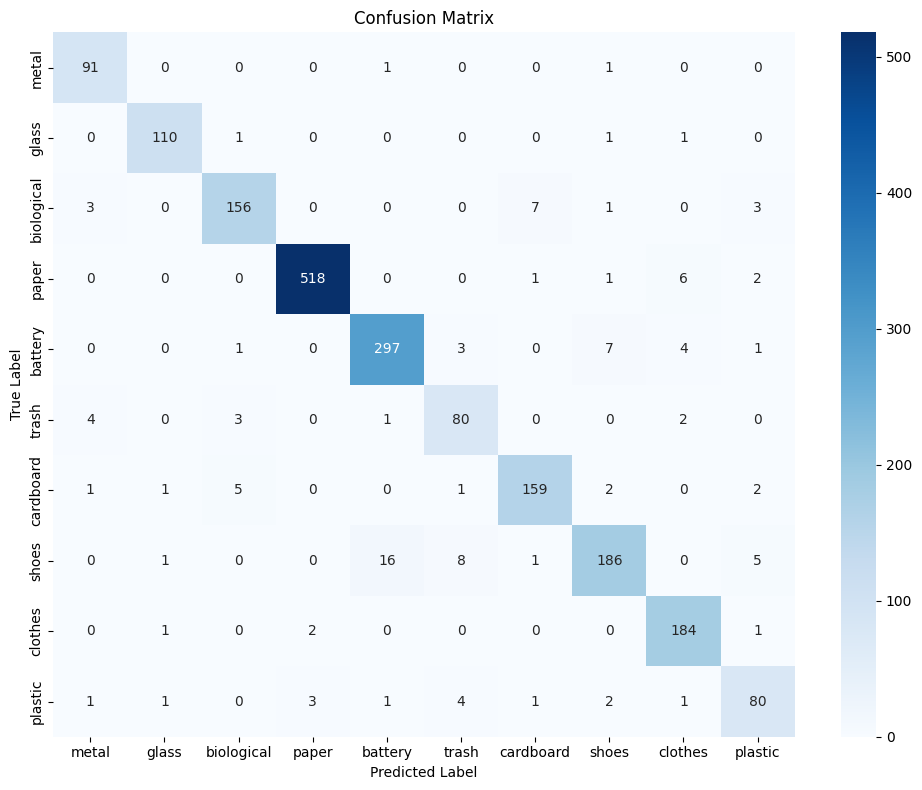

In [44]:
evaluate_model(model, test_loader, device, class_names=list(class_counts.keys()))

## Save Full Model

In [45]:
torch.save(model, "model.pth")

## Test an image from url

In [47]:
import requests
from io import BytesIO

def predict_image_from_url(model, image_url, device, class_names, image_size=224):
    """
    Predict the class of an image from a URL.

    Args:
        model: Trained PyTorch model.
        image_url (str): URL of the image to predict.
        device: torch.device (e.g., 'cuda' or 'cpu').
        class_names (list): List of class names.
        image_size (int): Image size for resizing (default: 224).
    """
    # Preprocessing pipeline
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # for pretrained models
                             # std=[0.229, 0.224, 0.225])
    ])

    # Load and transform image
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    # Show image and prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}", fontsize=14)
    plt.show()

    return predicted_class


In [52]:
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'platic', 'shoes', 'trash']

In [ ]:
model.eval()

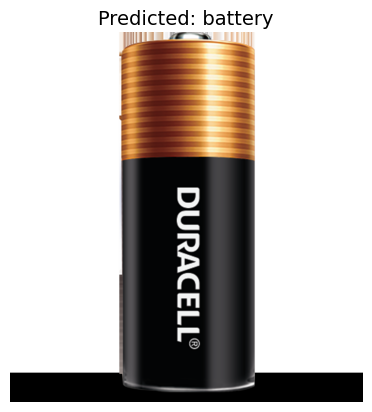

Predicted Class: battery


In [55]:
# Test on a real image URL
url = "https://www.duracell.com/wp-content/uploads/2022/06/eContent-PI-Duracell_Renders_N_Boost_Battery_Cell.png"
predicted = predict_image_from_url(model, url, device, class_names)
print("Predicted Class:", predicted)